In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import category_encoders as ce
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam,SGD,Adagrad
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score
import scipy as sci
import seaborn as sn

In [3]:
df = pd.read_excel('hse.xlsx')
df.drop('Rating_of_university', axis=1, inplace=True)

In [4]:
df

,ID,Passed,Position_in_list,Score_sum,Priority,Original_diploma,Priority_right,Number_of_seats,City,Field_of_study_code,Field_of_study_name,Program_name
0,171-316-925 54,False,152,308,3.0,False,False,0,Moscow,42.03.01,Реклама и связи с общественностью,Реклама и связи с общественностью
1,175-939-892 47,False,153,305,1.0,True,False,0,Moscow,42.03.01,Реклама и связи с общественностью,Реклама и связи с общественностью
2,175-090-852 80,False,154,304,3.0,True,False,0,Moscow,42.03.01,Реклама и связи с общественностью,Реклама и связи с общественностью
3,194-929-915 41,False,155,303,3.0,True,False,0,Moscow,42.03.01,Реклама и связи с общественностью,Реклама и связи с общественностью
4,192-060-802 50,False,156,303,1.0,False,False,0,Moscow,42.03.01,Реклама и связи с общественностью,Реклама и связи с общественностью
...,...,...,...,...,...,...,...,...,...,...,...,...
52253,149-776-575 37,False,390,52,1.0,False,False,15,Perm,40.03.01,Юриспруденция,Юриспруденция
52254,193-253-952 89,False,391,39,NaN,False,False,15,Perm,40.03.01,Юриспруденция,Юриспруденция
52255,160-635-747 63,False,392,37,2.0,False,False,15,Perm,40.03.01,Юриспруденция,Юриспруденция
52256,139-735-027 83,False,393,25,2.0,False,False,15,Perm,40.03.01,Юриспруденция,Юриспруденция


In [5]:
count = len(df.loc[(df["Passed"] == True) & (df["Priority"].isna())])
print("Number of rows where applicants passed the competition, but their chosen priority is NaN: " + str(count))

Number of rows where applicants passed the competition, but their chosen priority is NaN: 0


In [6]:
print("DataFrame count before: " + str(len(df)))
df.drop(df[df["Priority"].isna()].index, inplace=True)
print("DataFrame count after: " + str(len(df)))

DataFrame count before: 52258
DataFrame count after: 41411


In [7]:
count = len(df[df['Passed'] & ~df['Original_diploma']])
print("Number of applicants passed the competition but didn't provide the original diploma:")
print(count)

Number of applicants passed the competition but didn't provide the original diploma:
1


In [8]:
df.drop(df[df['Passed'] & ~df['Original_diploma']].index, inplace=True)

Text(0, 0.5, 'Количество')

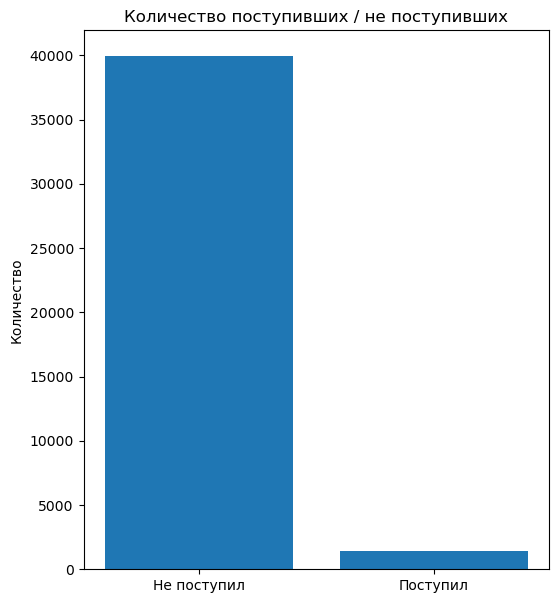

In [9]:
passed_groups = df.groupby(['Passed'])['Passed'].count()

x_pos = np.arange(len(passed_groups.keys()))

plt.rcParams["figure.figsize"] = (6, 7)
plt.bar(x_pos, passed_groups)

plt.xticks(x_pos, ['Не поступил', 'Поступил'])
plt.title('Количество поступивших / не поступивших')
plt.ylabel('Количество')

In [10]:
df.groupby('City')['City'].count().sort_values(ascending=False)

City
Moscow              30086
Saint Petersburg     6320
Nizhniy Novgorod     3327
Perm                 1677
Name: City, dtype: int64

In [11]:
new_df = df.drop(["Program_name", "Field_of_study_name"], axis=1)

In [12]:
def Shapiro_Wilk_test(data):
    data = np.array(data)
    result = sci.stats.shapiro(data)
    s_calc = result.statistic    # расчетное значение статистики критерия
    a_calc = result.pvalue    # расчетный уровень значимости
    
    p_value = round(0.05, 10)
    
    print(f"Расчетный уровень значимости: a_calc = {round(a_calc, 10)}")
    print(f"Заданный уровень значимости: a_level = {p_value}")
    
    if a_calc >= p_value:
        conclusion_ShW_test = f"Так как a_calc = {round(a_calc, 10)} >= a_level = {p_value}" + \
            ", то гипотеза о нормальности распределения по критерию Шапиро-Уилка ПРИНИМАЕТСЯ"
    else:
        conclusion_ShW_test = f"Так как a_calc = {round(a_calc, 10)} < a_level = {p_value}" + \
            ", то гипотеза о нормальности распределения по критерию Шапиро-Уилка ОТВЕРГАЕТСЯ"
    print(conclusion_ShW_test)

In [13]:
Shapiro_Wilk_test(new_df['Score_sum'])

Расчетный уровень значимости: a_calc = 0.0
Заданный уровень значимости: a_level = 0.05
Так как a_calc = 0.0 < a_level = 0.05, то гипотеза о нормальности распределения по критерию Шапиро-Уилка ОТВЕРГАЕТСЯ


C:\Users\shisha\miniconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


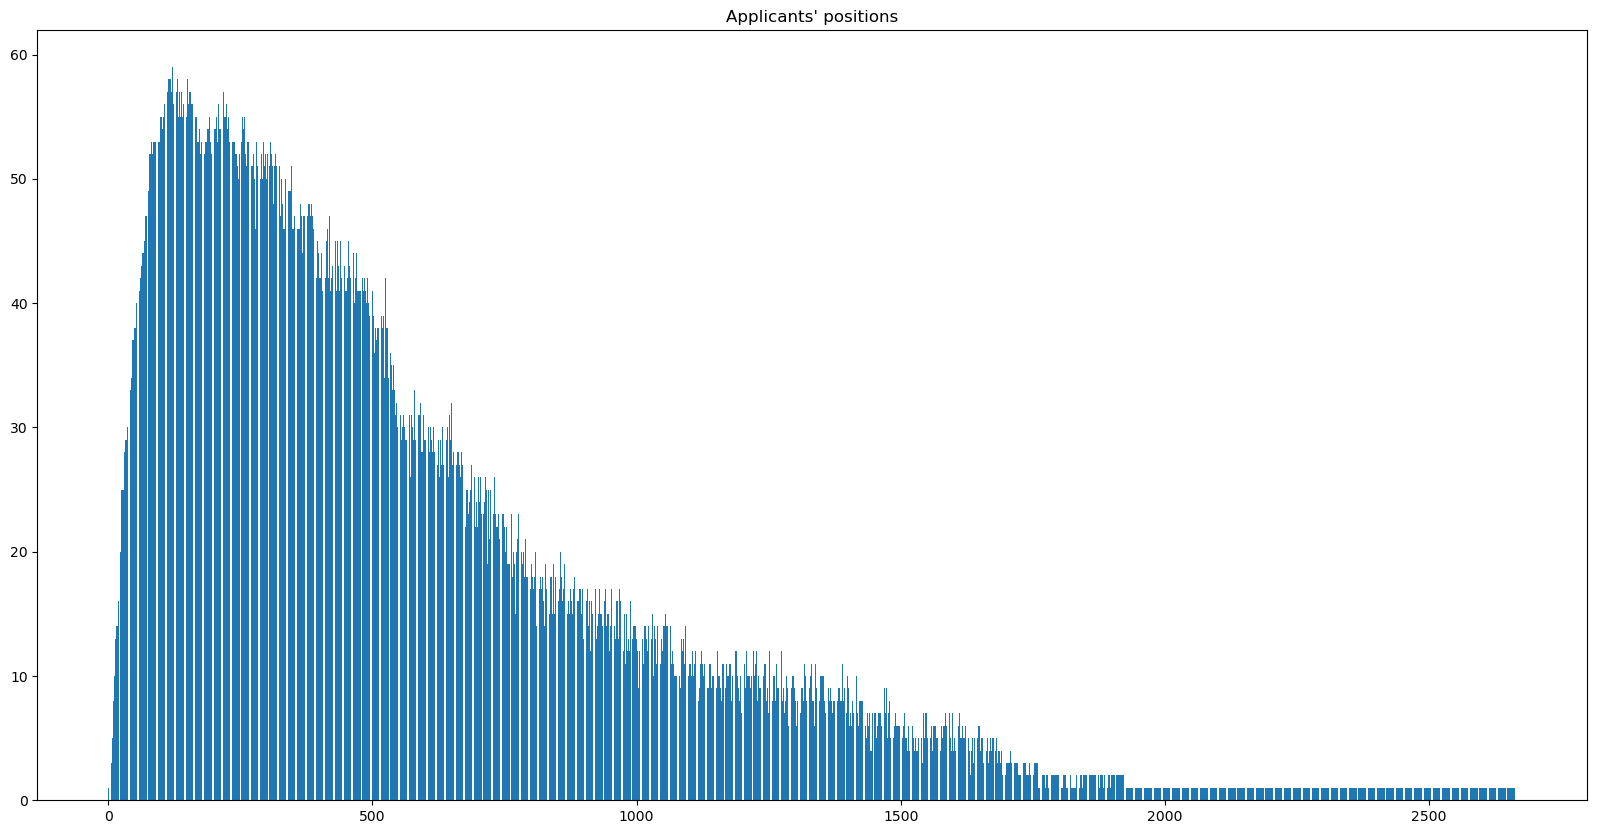

In [14]:
groups = df.sort_values('Position_in_list').groupby(['Position_in_list'])['Position_in_list'].count()

x_pos = np.arange(len(groups.keys()))

plt.rcParams["figure.figsize"] = (20,10)
plt.bar(x_pos, groups)

_ = plt.title("Applicants' positions")

In [15]:
positions_dict = df['Position_in_list'].value_counts().to_dict()
most_frequent = list(positions_dict.values())[0]
frequent_list = [key for key, value in positions_dict.items() if value == most_frequent]

print("The most frequent applicants' positions")
print(frequent_list)
print('Count: ' + str(most_frequent))

The most frequent applicants' positions
[125, 128]
Count: 59


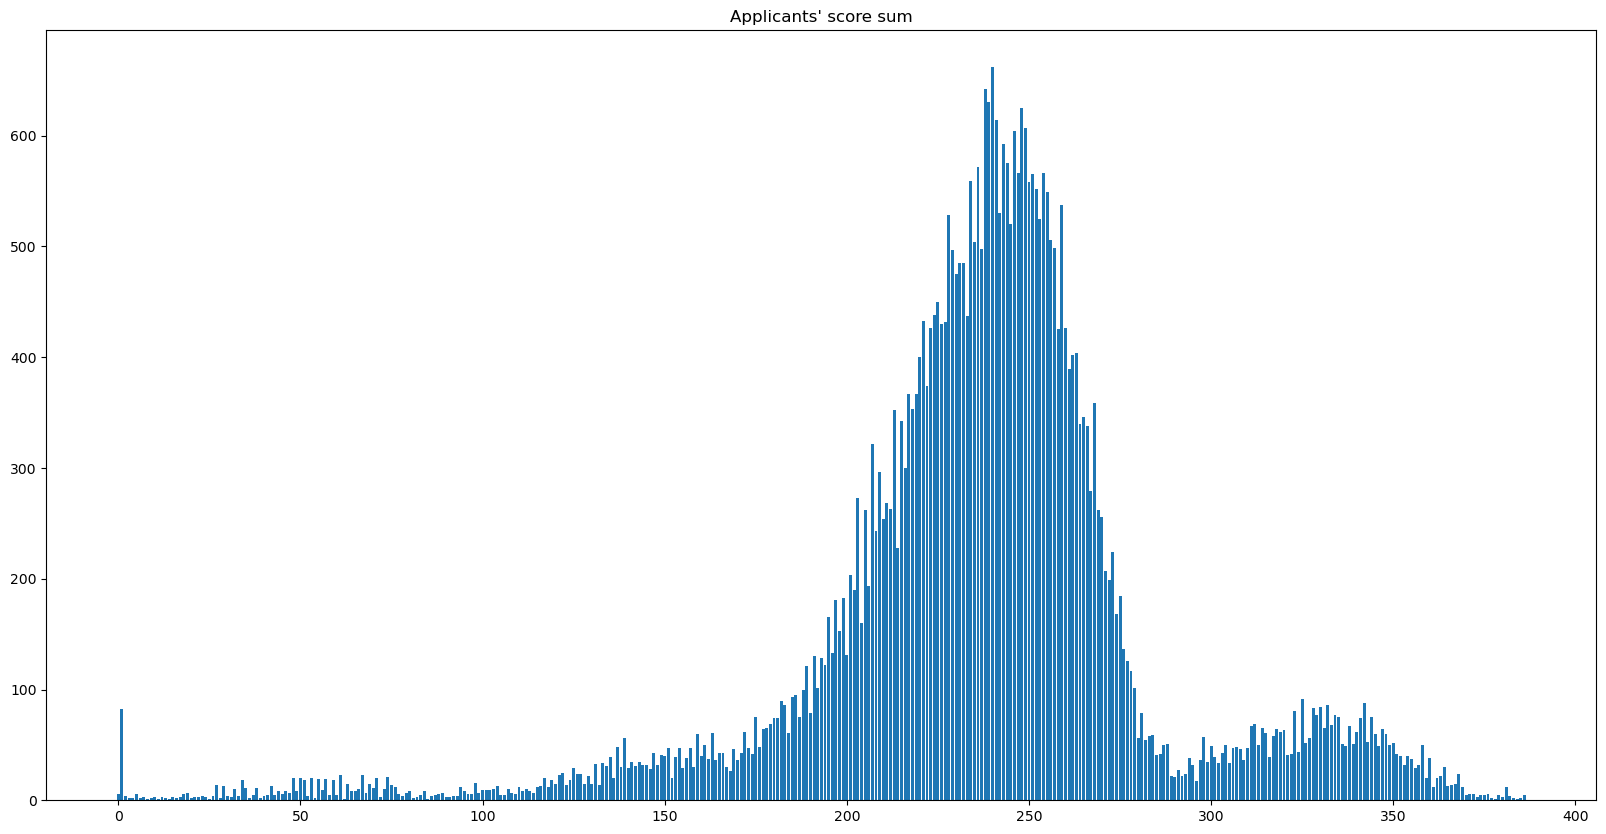

In [16]:
groups = df.sort_values('Score_sum').groupby(['Score_sum'])['Score_sum'].count()

x_pos = np.arange(len(groups.keys()))

plt.rcParams["figure.figsize"] = (20,10)
plt.bar(x_pos, groups)

_ = plt.title("Applicants' score sum")

In [17]:
position_mean = df['Position_in_list'].mean()
position_std = df['Position_in_list'].std()

score_mean = df['Score_sum'].mean()
score_std = df['Score_sum'].std()

priority_mean = df['Priority'].mean()
priority_std = df['Priority'].std()

seats_mean = df['Number_of_seats'].mean()
seats_std = df['Number_of_seats'].std()

In [18]:
def standardize(df, column_name):
    df[column_name] = (df[column_name] - df[column_name].mean()) / df[column_name].std()
    
standardize(new_df, 'Position_in_list')
standardize(new_df, 'Score_sum')
standardize(new_df, 'Priority')
standardize(new_df, 'Number_of_seats')

new_df.replace(True, 1, inplace=True)
new_df.replace(False, 0, inplace=True)

In [19]:
new_df

,ID,Passed,Position_in_list,Score_sum,Priority,Original_diploma,Priority_right,Number_of_seats,City,Field_of_study_code
0,171-316-925 54,0,-0.895615,0.986757,0.558475,0,0,-1.125465,Moscow,42.03.01
1,175-939-892 47,0,-0.893507,0.926210,-0.817690,1,0,-1.125465,Moscow,42.03.01
2,175-090-852 80,0,-0.891399,0.906028,0.558475,1,0,-1.125465,Moscow,42.03.01
3,194-929-915 41,0,-0.889291,0.885846,0.558475,1,0,-1.125465,Moscow,42.03.01
4,192-060-802 50,0,-0.887183,0.885846,-0.817690,0,0,-1.125465,Moscow,42.03.01
...,...,...,...,...,...,...,...,...,...,...
52252,159-756-807 32,0,-0.396033,-4.058824,-0.817690,0,0,-0.388759,Perm,40.03.01
52253,149-776-575 37,0,-0.393925,-4.179918,-0.817690,0,0,-0.388759,Perm,40.03.01
52255,160-635-747 63,0,-0.389709,-4.482653,-0.129607,0,0,-0.388759,Perm,40.03.01
52256,139-735-027 83,0,-0.387601,-4.724841,-0.129607,0,0,-0.388759,Perm,40.03.01


In [20]:
groups = df.groupby(['Field_of_study_name'])['Field_of_study_name'].count()
print('How many times a field of study occurs in the dataset')
print(groups.sort_values(ascending=False))
print('Count: ' + str(len(groups)))

How many times a field of study occurs in the dataset
Field_of_study_name
Юриспруденция                                      3055
Менеджмент                                         2928
Прикладная математика и информатика                2903
Экономика                                          2782
Программная инженерия                              2553
Информатика и вычислительная техника               2458
Бизнес-информатика                                 2338
Медиакоммуникации                                  1794
Реклама и связи с общественностью                  1758
Востоковедение и африканистика                     1548
Филология                                          1533
Информационная безопасность                        1502
Государственное и муниципальное управление         1343
Лингвистика                                        1335
Инфокоммуникационные технологии и системы связи    1168
История                                            1074
Математика                    

In [21]:
network_df = new_df.drop(['ID'], axis=1)

encoder = ce.BinaryEncoder(cols = ['City', 'Field_of_study_code'] , return_df = True)
network_df = encoder.fit_transform(network_df)

In [22]:
network_df

,Passed,Position_in_list,Score_sum,Priority,Original_diploma,Priority_right,Number_of_seats,City_0,City_1,City_2,Field_of_study_code_0,Field_of_study_code_1,Field_of_study_code_2,Field_of_study_code_3,Field_of_study_code_4,Field_of_study_code_5
0,0,-0.895615,0.986757,0.558475,0,0,-1.125465,0,0,1,0,0,0,0,0,1
1,0,-0.893507,0.926210,-0.817690,1,0,-1.125465,0,0,1,0,0,0,0,0,1
2,0,-0.891399,0.906028,0.558475,1,0,-1.125465,0,0,1,0,0,0,0,0,1
3,0,-0.889291,0.885846,0.558475,1,0,-1.125465,0,0,1,0,0,0,0,0,1
4,0,-0.887183,0.885846,-0.817690,0,0,-1.125465,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52252,0,-0.396033,-4.058824,-0.817690,0,0,-0.388759,1,0,0,0,0,1,1,0,1
52253,0,-0.393925,-4.179918,-0.817690,0,0,-0.388759,1,0,0,0,0,1,1,0,1
52255,0,-0.389709,-4.482653,-0.129607,0,0,-0.388759,1,0,0,0,0,1,1,0,1
52256,0,-0.387601,-4.724841,-0.129607,0,0,-0.388759,1,0,0,0,0,1,1,0,1


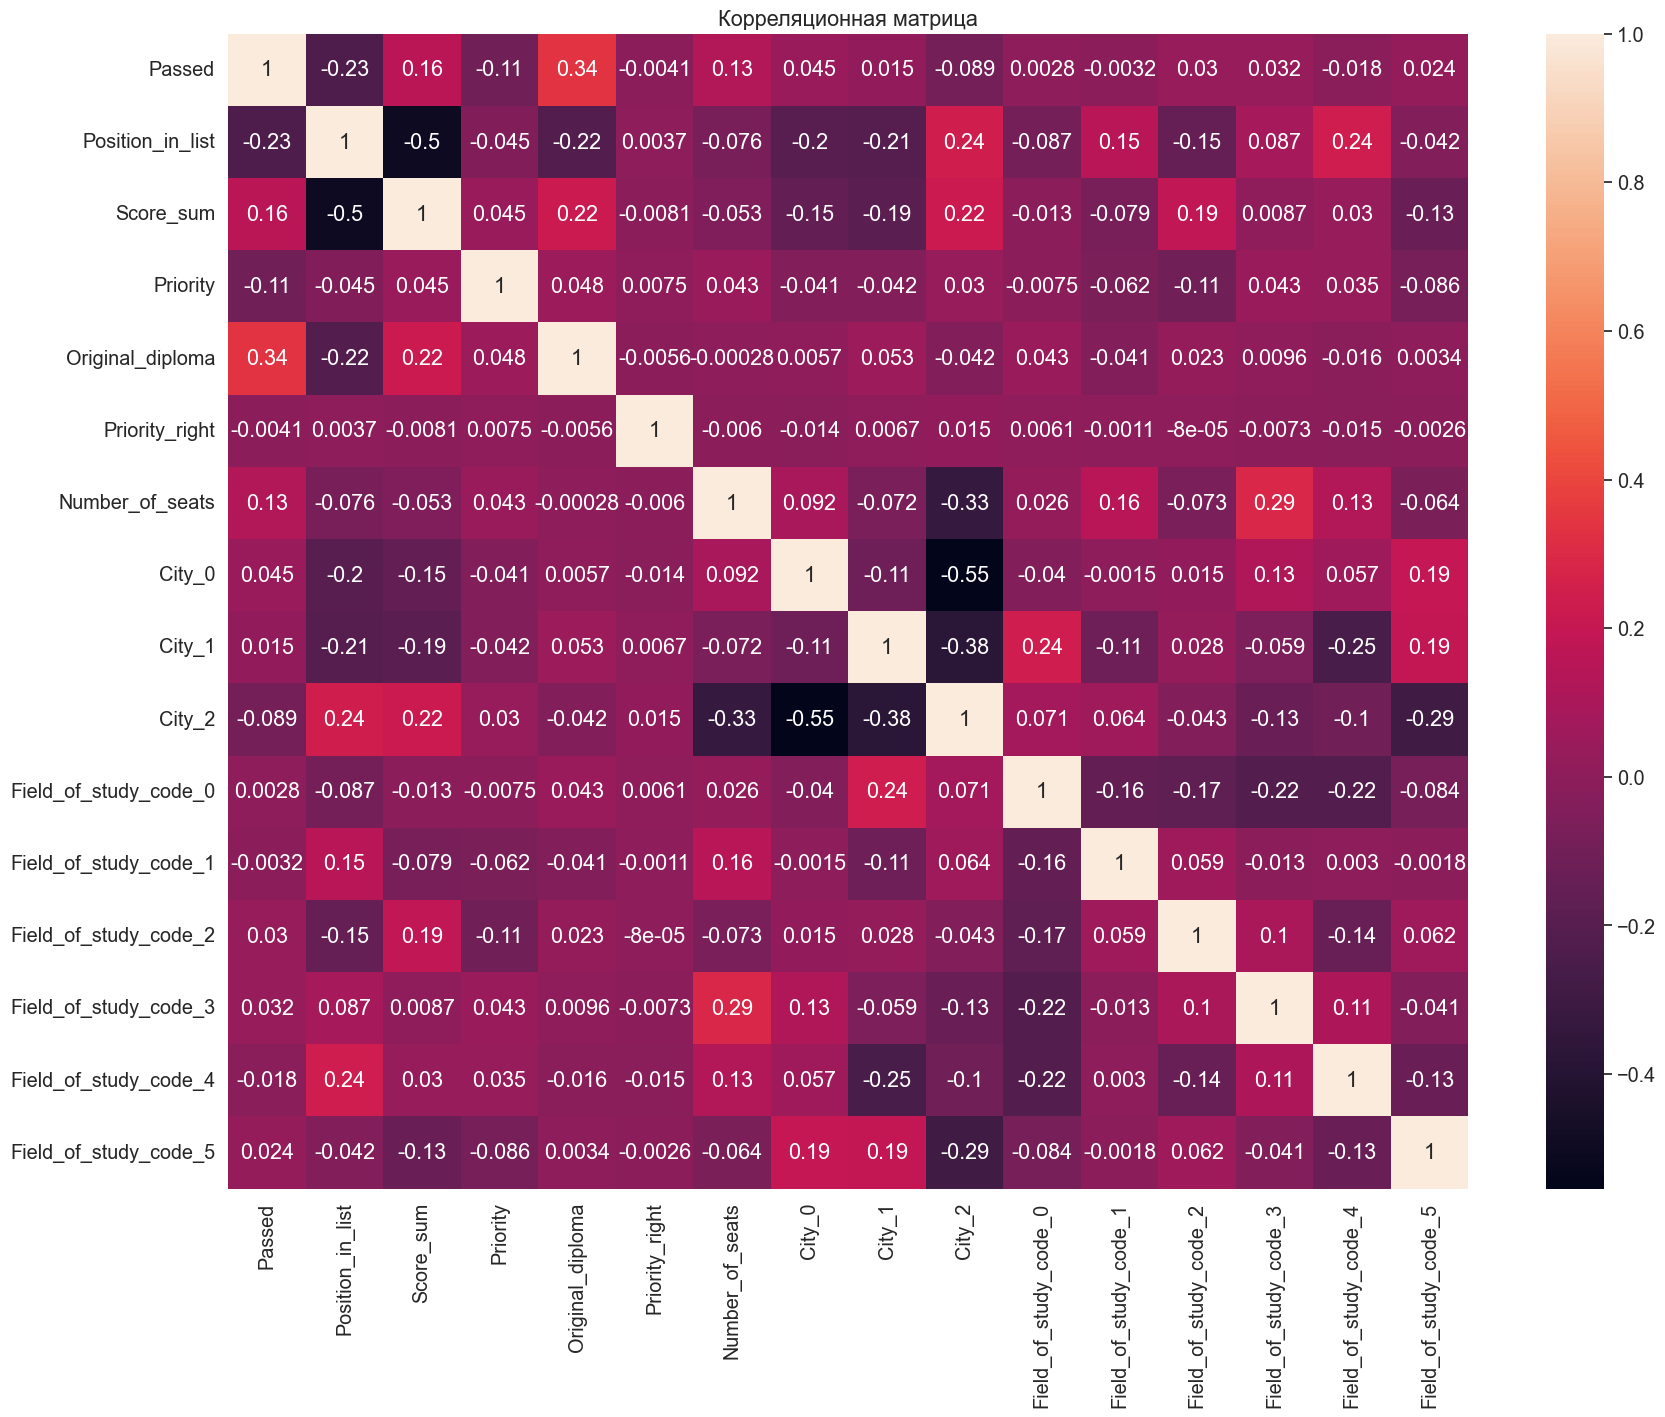

In [23]:
corr_matrix = network_df.corr(method='spearman')

plt.rcParams["figure.figsize"] = (20,15)
sn.set(font_scale=1.3)
ax = sn.heatmap(corr_matrix, annot=True)
ax.set(title="Корреляционная матрица")
plt.show()

In [24]:
#X_train, X_validation, Y_train, Y_validation = train_test_split(network_df.drop('Passed', axis=1),
                                                                #network_df['Passed'], test_size=0.1)

#X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.1)

In [25]:
def read_excel(excel_path):
    df = pd.read_excel(excel_path)
    
    df.rename(columns={"D1": 'Passed'}, inplace=True)
    
    df_x = df.rename(columns={"X" + str(i + 1): column_name
                                                 for i, column_name in enumerate(network_df.drop('Passed', axis=1).columns)})
    
    y = df["Passed"]
    
    return df_x.drop('Passed', axis=1), y

X_train, Y_train = read_excel(r'train.xlsx')
X_test, Y_test = read_excel(r'test.xlsx')
X_validation, Y_validation = read_excel(r'validation.xlsx')

In [26]:
print(len(Y_validation[Y_validation == 1]))
print(len(Y_test[Y_test == 1]))

143
120


In [27]:
def save_df(x_vals_df, y_vals, output_df_path):
    output_df = x_vals_df.copy()
    
    for i, column_name in enumerate(x_vals_df.columns):
        output_df.rename(columns={column_name: "X" + str(i + 1)}, inplace=True)
        
    output_df['D1'] = y_vals
    
    output_df.to_excel(output_df_path, index=False)

#save_df(X_train, Y_train, r'data\train.xlsx')
#save_df(X_test, Y_test, r'data\test.xlsx')
#save_df(X_validation, Y_validation, r'data\validation.xlsx')

In [28]:
def getModel(dropout=0.00, neurons_first=500, neurons_second=250, neurons_last=1, learningRate=0.1):
    model = Sequential()
    model.add(Dense(neurons_first, activation='relu',
                    name='Dense_first'))
    model.add(Dropout(dropout, name='Dropout_first'))
    model.add(Dense(neurons_second, activation='relu',
                    name='Dense_second'))
    model.add(Dropout(dropout, name='Dropout_second'))
    model.add(Dense(30, activation='relu',
                    name='Dense_third'))
    #model.add(Dense(5, activation='relu',
                    #name='Dense_4'))
    model.add(Dense(neurons_last, activation='tanh',
                    name='Result'))
    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                 metrics=['accuracy', 'precision', 'recall', 'f1_score', 'auc'])
    return model

In [29]:
input_neuron_count = len(X_train.columns)
output_neuron_count = 1
class_weights = {0: 1, 1: 2.5}

model = getModel(neurons_first=input_neuron_count, neurons_second=40, neurons_last=output_neuron_count)

history = model.fit(X_train, Y_train, validation_data=(X_validation, Y_validation),
                    epochs=200, batch_size=128, verbose=False, class_weight=class_weights)

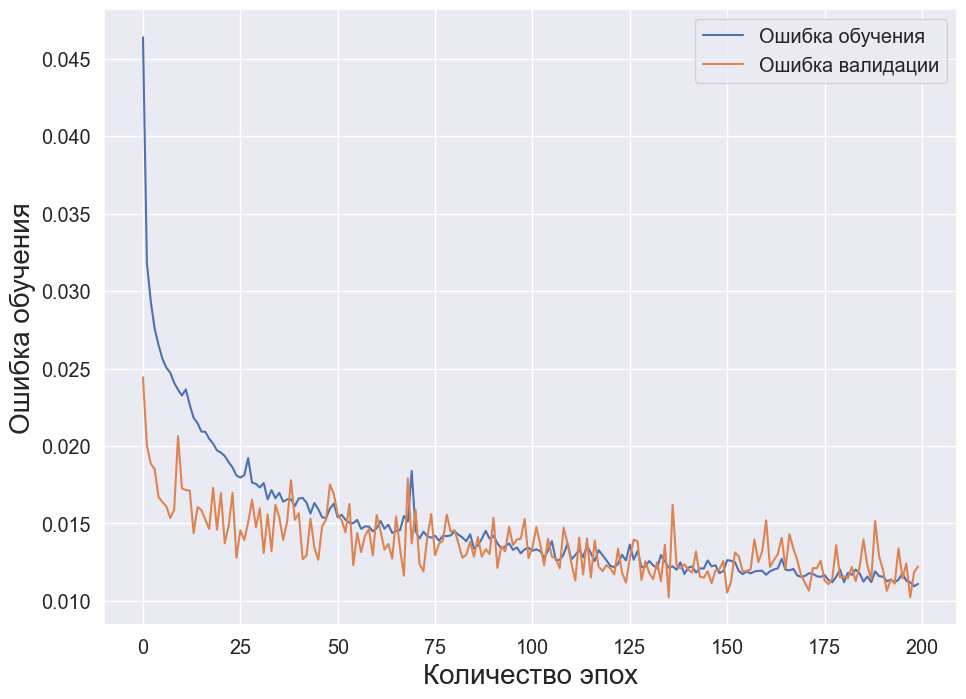

In [30]:
plt.rcParams["figure.figsize"] = (11, 8)

line1, = plt.plot(history.history['loss'], label='Ошибка обучения')
line2, = plt.plot(history.history['val_loss'], label='Ошибка валидации')

plt.xlabel('Количество эпох', fontsize=20)
plt.ylabel('Ошибка обучения', fontsize=20)

plt.legend(handles=[line1, line2])

In [31]:
results = model.evaluate(X_validation, Y_validation)

130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - accuracy: 0.9834 - auc: 0.9890 - f1_score: 0.0614 - loss: 0.0129 - precision: 0.6975 - recall: 0.8280


In [32]:
def standardize_value(value, mean, std):
    return (value - mean) / std

def find_code(code, df_with_fields, df_with_codes):
    result_df = df_with_fields.loc[df_with_fields['Field_of_study_code'] == code]['Field_of_study_code']
    
    if len(result_df) == 0:
        return None
    
    result_index = result_df.index.tolist()[0]
    
    return df_with_codes.loc[result_index].iloc[10:16].tolist()

def find_city_code(city, df_with_cities, df_with_codes):
    result_df = df_with_cities.loc[df_with_cities['City'] == city]['City']
    
    if len(result_df) == 0:
        return None
    
    result_index = result_df.index.tolist()[0]
    
    return df_with_codes.loc[result_index].iloc[7:10].tolist()

def predict(values, model):
    code_list = find_code(values['Field_of_study_code'], df, network_df)
    
    if code_list == None:
        return float('NaN')
    
    city_list = find_city_code(values['City'], df, network_df)
    
    if city_list == None:
        return float('NaN')
    
    position = standardize_value(values['Position_in_list'], position_mean, position_std)
    score = standardize_value(values['Score_sum'], score_mean, score_std)
    priority = standardize_value(values['Priority'], priority_mean, priority_std)
    original = 1 if values['Original_diploma'] else 0
    priority_right = 1 if values['Priority_right'] else 0
    seats = standardize_value(values['Number_of_seats'], seats_mean, seats_std)
    
    df_to_predict = pd.DataFrame(columns=network_df.columns[1:len(network_df.columns)])
    df_to_predict.loc[0] = [position, score, priority, original, priority_right, seats, *city_list, *code_list]
    
    return model.predict(df_to_predict[:1], verbose=False)

In [33]:
predict({
    'Position_in_list': 222,
    'Score_sum': 287,
    'Priority': 2,
    'Original_diploma': True,
    'Priority_right': False,
    'Number_of_seats': 21,
    'City': 'Moscow',
    'Field_of_study_code': '10.03.01',
}, model)[0][0]

0.46729037

In [34]:
test_prediction = model.predict(X_test).reshape(-1)

117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step


In [35]:
correct_positive = 0
correct_count = 0
incorrect_count = 0

for a, b in zip(Y_test, test_prediction):
    if round(b, 0) == a:
        if a == 1:
            correct_positive += 1
        correct_count += 1
    else:
        incorrect_count += 1
        
print("Total correct predictions: " + str(correct_count))
print("Total incorrect predictions: " + str(incorrect_count))

total_enrolled = len(Y_test[Y_test == 1])

print("Total correct predictions for enrolled: " + str(correct_positive) + " of " + str(total_enrolled))

Total correct predictions: 3675
Total incorrect predictions: 52
Total correct predictions for enrolled: 106 of 120


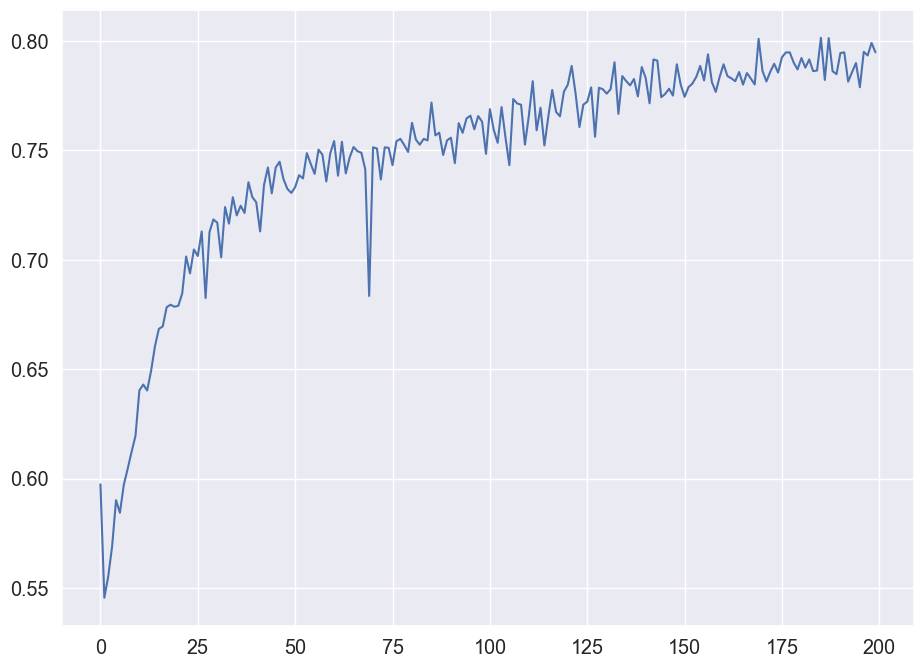

In [36]:
plt.plot(history.history['precision'])

In [37]:
predict({
    'Position_in_list': 60,
    'Score_sum': 280,
    'Priority': 1,
    'Original_diploma': True,
    'Priority_right': False,
    'Number_of_seats': 6,
    'City': 'Moscow',
    'Field_of_study_code': '10.03.01',
}, model)[0][0]

0.3160829

In [38]:
r2_score(Y_test, test_prediction)

0.6808991402997939

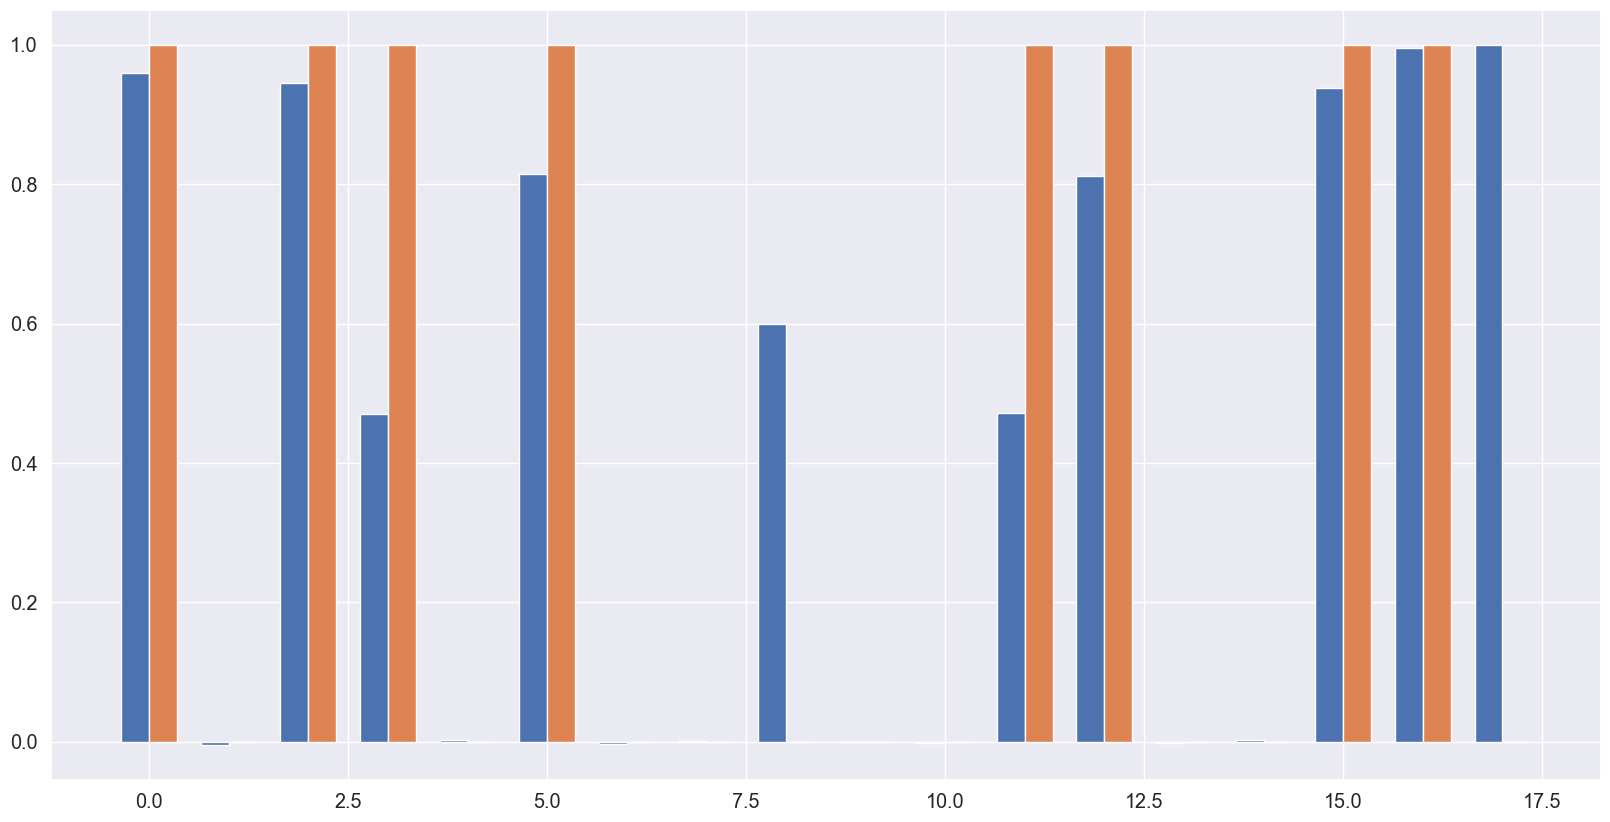

In [39]:
j = pd.DataFrame()
j['Real'] = Y_test
j['Predict'] = test_prediction

true_indexes = [19, 24, 36, 71, 75, 3471, 3547, 3618]
false_indexes = [0, 1, 2, 3, 4, 3721, 3722, 3723, 459, 2276]

indexes = [true_indexes[0], false_indexes[0], true_indexes[1], true_indexes[2],
          false_indexes[1], true_indexes[3], false_indexes[2], false_indexes[3],
          false_indexes[8], false_indexes[4], false_indexes[5], true_indexes[4], true_indexes[5],
          false_indexes[6], false_indexes[7], true_indexes[6], true_indexes[7], false_indexes[9]]

x_pos = np.arange(len(true_indexes) + len(false_indexes))
width = 0.35

plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots()
rects1 = ax.bar(x_pos - width / 2, j['Predict'].loc[indexes], width)
rects2 = ax.bar(x_pos + width / 2, j['Real'].loc[indexes], width)

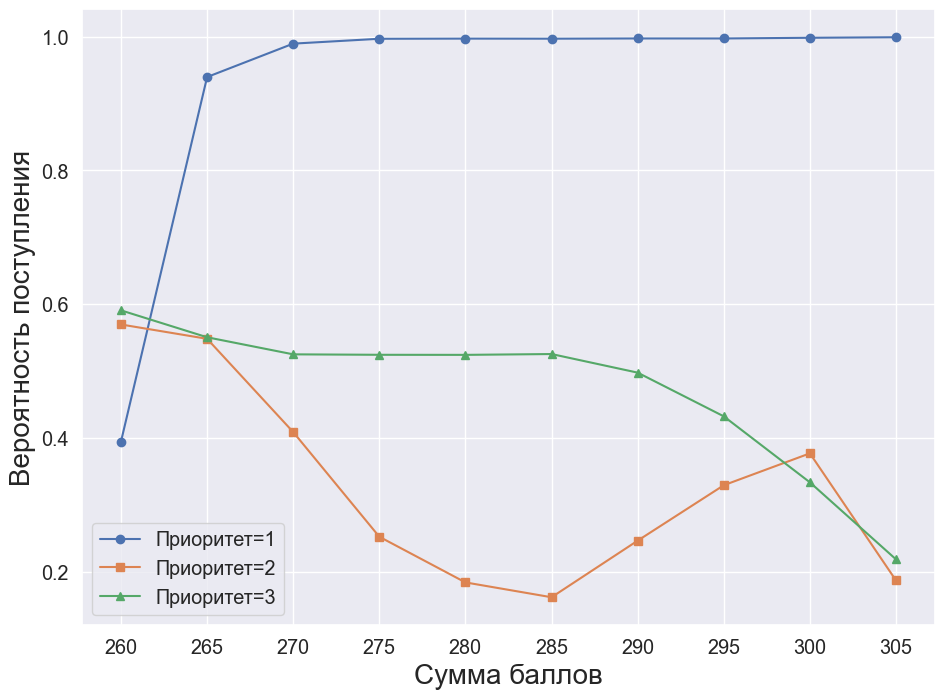

In [40]:
base_info = {
    'Original_diploma': True,
    'Priority_right': False,
    'City': 'Moscow',
    'Field_of_study_code': '09.03.01',
}

first_predict = dict(base_info)
first_predict["Priority"] = 1
first_predict["Number_of_seats"] = 57

x_values = [260 + i *5 for i in range(10)]
y_values = [predict({**first_predict, "Score_sum" : sum, "Position_in_list": 395 - (i * 10)}, model)[0][0]
            for i, sum in enumerate(x_values)]

plt.rcParams["figure.figsize"] = (11, 8)

line1, = plt.plot(x_values, y_values, label="Приоритет=1", marker="o")

y_values = [predict({**first_predict, "Score_sum" : sum, "Position_in_list": 395 - (i * 10), "Priority": 2}, model)[0][0]
            for i, sum in enumerate(x_values)]

line2, = plt.plot(x_values, y_values, label="Приоритет=2", marker="s")

y_values = [predict({**first_predict, "Score_sum" : sum, "Position_in_list": 395 - (i * 10), "Priority": 3}, model)[0][0]
            for i, sum in enumerate(x_values)]

line3, = plt.plot(x_values, y_values, label="Приоритет=3", marker="^")

plt.xlabel('Сумма баллов', fontsize=20)
plt.ylabel('Вероятность поступления', fontsize=20)
plt.xticks(x_values)

plt.legend(handles=[line1, line2, line3])

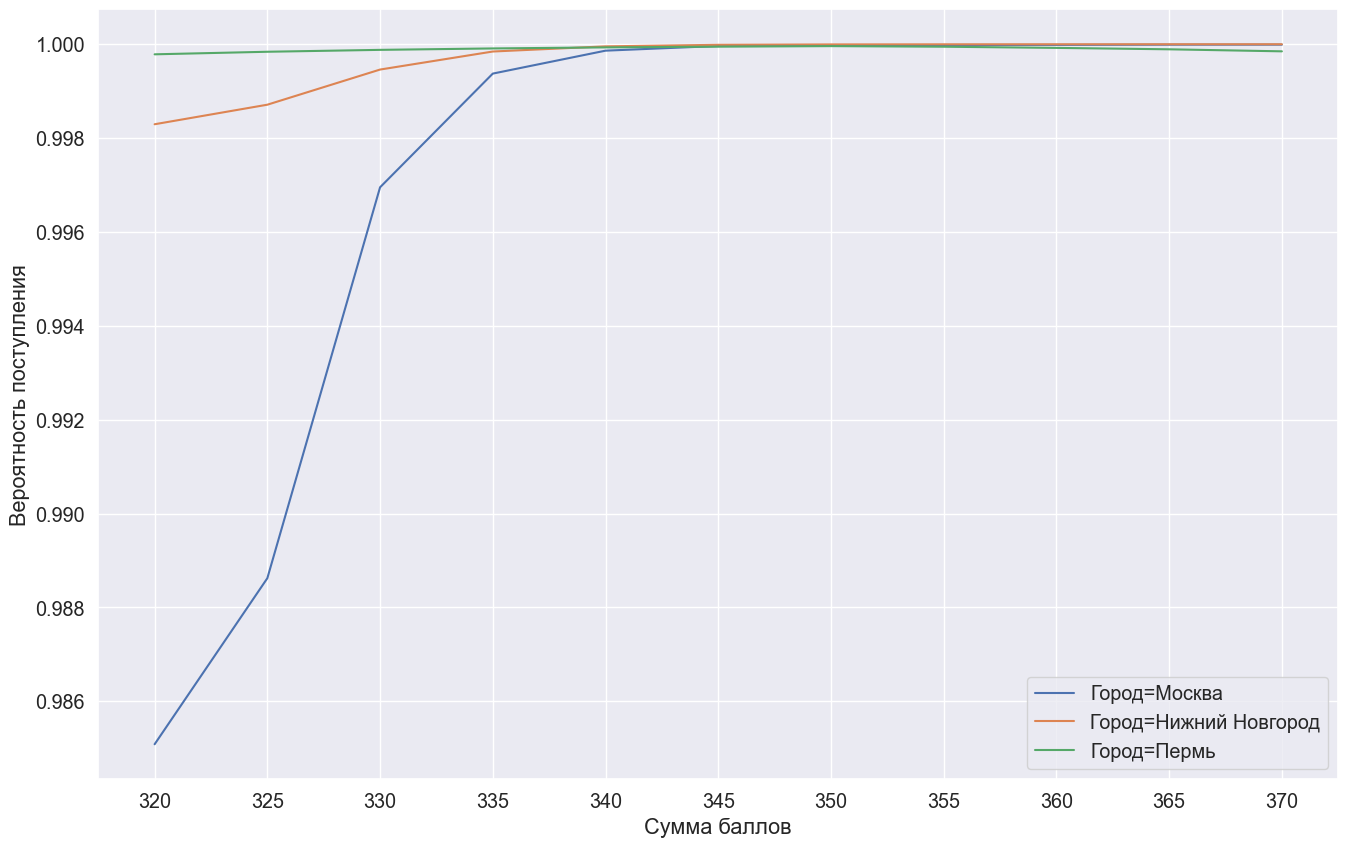

In [41]:
another_predict = {
    'Priority': 1,
    'Number_of_seats': 18,
    'Original_diploma': True,
    'Priority_right': False,
    'City': 'Moscow',
    'Field_of_study_code': '40.03.01',
}

x_values = [320 + i *5 for i in range(11)]
y_values = [predict({**another_predict, "Score_sum" : sum, "Position_in_list": 133 - (i * 8)}, model)[0][0]
            for i, sum in enumerate(x_values)]

plt.rcParams["figure.figsize"] = (16, 10)

line1, = plt.plot(x_values, y_values, label="Город=Москва")

y_values = [predict({**another_predict, "Score_sum" : sum, "Position_in_list": 133 - (i * 8), "City": 'Nizhniy Novgorod'}, model)[0][0]
            for i, sum in enumerate(x_values)]

line2, = plt.plot(x_values, y_values, label="Город=Нижний Новгород")

y_values = [predict({**another_predict, "Score_sum" : sum, "Position_in_list": 133 - (i * 8), "City": 'Perm'}, model)[0][0]
            for i, sum in enumerate(x_values)]

line3, = plt.plot(x_values, y_values, label="Город=Пермь")

plt.xlabel('Сумма баллов')
plt.ylabel('Вероятность поступления')
plt.xticks(x_values)

plt.legend(handles=[line1, line2, line3])

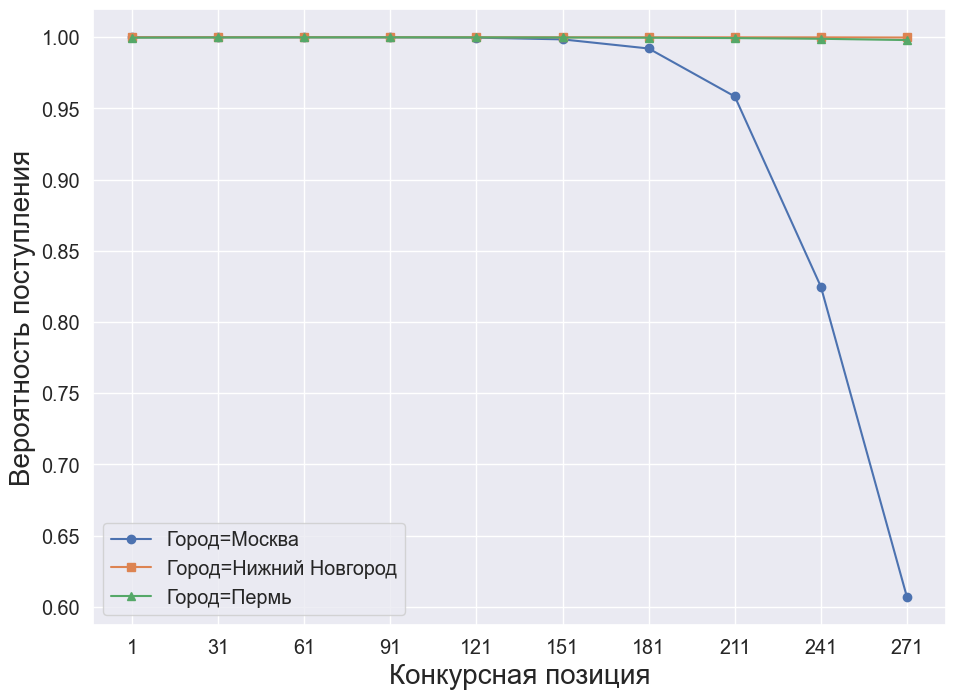

In [42]:
another_predict = {
    'Priority': 1,
    'Number_of_seats': 18,
    'Original_diploma': True,
    'Priority_right': False,
    'Score_sum': 357,
    'City': 'Moscow',
    'Field_of_study_code': '40.03.01',
}

x_values = [1 + i *30 for i in range(10)]
y_values = [predict({**another_predict, "Position_in_list": pos}, model)[0][0]
            for i, pos in enumerate(x_values)]

plt.rcParams["figure.figsize"] = (11, 8)

line1, = plt.plot(x_values, y_values, label="Город=Москва", marker="o")

y_values = [predict({**another_predict, "Position_in_list": pos, "City": 'Nizhniy Novgorod'}, model)[0][0]
            for i, pos in enumerate(x_values)]

line2, = plt.plot(x_values, y_values, label="Город=Нижний Новгород", marker="s")

y_values = [predict({**another_predict, "Position_in_list": pos, "City": 'Perm'}, model)[0][0]
            for i, pos in enumerate(x_values)]

line3, = plt.plot(x_values, y_values, label="Город=Пермь", marker="^")

plt.xlabel('Конкурсная позиция', fontsize=20)
plt.ylabel('Вероятность поступления', fontsize=20)
plt.xticks(x_values)

plt.legend(handles=[line1, line2, line3])

In [43]:
#model.save('model.keras')